In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.examples.tutorials.mnist import input_data
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import Sequential
import glob
import numpy as np
import pandas as pd
import os
import shutil
import cv2
from keras.preprocessing.image import ImageDataGenerator
from skimage.io import imread
import scipy
import random

In [0]:
def encoder(X,encoding_size,IMAGE_SIZE=28):
  layer = Conv2D(64,kernel_size=(4,4),strides=1,padding="SAME",activation='relu')(X)
  layer = MaxPooling2D(pool_size=(2,2),padding="VALID")(layer)
  layer = Conv2D(64,kernel_size=(4,4),strides=1,padding="SAME",activation='relu')(layer)
  layer = MaxPooling2D(pool_size=(2,2),padding="VALID")(layer)
  layer = Conv2D(64,kernel_size=(4,4),strides=1,padding="SAME",activation='relu')(layer)
  layer = Flatten()(layer)
  mu = Dense(encoding_size)(layer)
  log_sd = Dense(encoding_size)(layer)
  #z = tf.random_normal(shape=[tf.shape(layer)[0],encoding_size])
  z = tf.random_normal(tf.stack([tf.shape(layer)[0], encoding_size])) 
  z = mu + tf.multiply(tf.exp(log_sd),z)
  return mu,log_sd,z

def decoder(z,IMAGE_SIZE=28):
  layer = Dense(25,activation='relu')(z)
  layer = Dense(49,activation='relu')(layer)
  layer = Reshape(target_shape=(7,7,1))(layer)
  layer = Conv2DTranspose(64,kernel_size=(4,4),strides=2,padding="SAME",activation='relu')(layer)
  layer = Conv2DTranspose(64,kernel_size=(4,4),strides=2,padding="SAME",activation='relu')(layer)
  layer = Conv2D(64,kernel_size=(4,4),strides=1,padding="SAME",activation='relu')(layer)
  print(layer.shape)
  layer = Flatten()(layer)
  layer = Dense(IMAGE_SIZE*IMAGE_SIZE,activation='sigmoid')(layer)
  output = Reshape(target_shape=(IMAGE_SIZE,IMAGE_SIZE,1))(layer)
  print('output',output.shape)
  return output
  


In [0]:
def run(encoding_size=8,
       IMAGE_SIZE = 28,
       batch_size = 64 , 
       n_epochs = 50):
  
  random.seed(999)
  mnist = input_data.read_data_sets('MNIST_data')
  train_steps_per_epoch = mnist.train.num_examples // batch_size
  val_steps_per_epoch = mnist.validation.num_examples // batch_size
  
  tf.reset_default_graph()
  X = tf.placeholder(dtype=tf.float32,shape=[None,IMAGE_SIZE,IMAGE_SIZE,1])
  mu,log_sd,z = encoder(X,encoding_size=encoding_size)
  output = decoder(z)
  kl_loss = tf.square(tf.exp(log_sd)) + tf.square(mu) - 2.0*log_sd - 1.0
  kl_loss = 0.50 * tf.reduce_sum(kl_loss,axis=1)
  kl_loss = tf.reduce_mean(kl_loss)
  rc_loss = tf.square(X-output)
  rc_loss = tf.reduce_sum(rc_loss,axis=[1,2,3])
  rc_loss = tf.reduce_mean(rc_loss)
  loss = rc_loss + kl_loss
  optimizer = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(loss)
  
  with tf.device('/gpu:0'):
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      train_rc_loss = []
      train_kl_loss = []
      train_total_loss = []
      val_rc_loss = []
      val_kl_loss = []
      val_total_loss = []
      for epoch in range(n_epochs):
        epoch_total = 0.0
        epoch_kl = 0.0
        epoch_rc = 0.0
        for j in range(train_steps_per_epoch):
          batch = mnist.train.next_batch(batch_size=batch_size)[0]
          batch = batch.reshape([-1,IMAGE_SIZE,IMAGE_SIZE,1])
          _, kl,rc,total = sess.run([optimizer,kl_loss,rc_loss,loss],feed_dict={X:batch})
          epoch_total = epoch_total + total / float(train_steps_per_epoch)
          epoch_kl = epoch_kl + kl / float(train_steps_per_epoch)
          epoch_rc = epoch_rc +rc / float(train_steps_per_epoch)
        print('Epoch %d:\nTrain Losses\nKL Loss: %.10f\tRC Loss: %.10f\tTotal Loss: %.10f\n'%(epoch,epoch_kl,epoch_rc,epoch_total))
        train_rc_loss.append(epoch_rc)
        train_kl_loss.append(epoch_kl)
        train_total_loss.append(epoch_total)
        
        epoch_total = 0.0
        epoch_kl = 0.0
        epoch_rc = 0.0
        for j in range(val_steps_per_epoch):
          batch = mnist.validation.next_batch(batch_size=batch_size)[0]
          batch = batch.reshape([-1,IMAGE_SIZE,IMAGE_SIZE,1])
          kl,rc,total = sess.run([kl_loss,rc_loss,loss],feed_dict={X:batch})
          epoch_total = epoch_total + total / float(val_steps_per_epoch)
          epoch_kl = epoch_kl + np.mean(kl) / float(val_steps_per_epoch)
          epoch_rc = epoch_rc + np.mean(rc) / float(val_steps_per_epoch)
        print('Epoch %d:\nValidation Losses\nKL Loss: %.10f\tRC Loss: %.10f\tTotal Loss: %.10f\n'%(epoch,epoch_kl,epoch_rc,epoch_total))
        val_rc_loss.append(epoch_rc)
        val_kl_loss.append(epoch_kl)
        val_total_loss.append(epoch_total)
        
        if (epoch+1) % 10 == 0:
          
          train_batch = mnist.train.next_batch(batch_size=5)[0]
          train_batch = train_batch.reshape([-1,IMAGE_SIZE,IMAGE_SIZE,1])
          kl,rc,total,train_model_output = sess.run([kl_loss,rc_loss,loss,output],feed_dict={X:train_batch})
          
          val_batch = mnist.validation.next_batch(batch_size=5)[0]
          val_batch = val_batch.reshape([-1,IMAGE_SIZE,IMAGE_SIZE,1])
          kl,rc,total,val_model_output = sess.run([kl_loss,rc_loss,loss,output],feed_dict={X:val_batch})
          
          plt.figure()
          for i in range(1,6):
            plt.subplot(2,5,i)
            plt.imshow(train_batch[i-1].reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')
          for i in range(6,11):
            plt.subplot(2,5,i)
            plt.imshow(train_model_output[i-6].reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')
          plt.savefig('train_reconstructions_'+str(encoding_size)+'_'+str(epoch+1)+'.png')
          plt.show()
          
          plt.figure()
          for i in range(1,6):
            plt.subplot(2,5,i)
            plt.imshow(val_batch[i-1].reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')
          for i in range(6,11):
            plt.subplot(2,5,i)
            plt.imshow(val_model_output[i-6].reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')
          plt.savefig('val_reconstructions_'+str(encoding_size)+'_'+str(epoch+1)+'.png')
          plt.show()
          
          
          print('New generated images...')
          plt.figure()
          for i in range(1,26):
            sample = np.random.normal(0,1,[1,encoding_size])
            model_output = sess.run(output,feed_dict={z:sample})
            plt.subplot(5, 5, i)
            plt.imshow(model_output[0].reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')
          plt.savefig('generated_images_'+str(encoding_size)+'_'+str(epoch+1)+'.png')
          plt.show()

      
        if ((epoch+1)%5 == 0 or epoch == 0) and encoding_size == 2:

          latent_space = []
          labels_arr = []
          for j in range(val_steps_per_epoch):
            batch,labels = mnist.validation.next_batch(batch_size=batch_size)
            batch = batch.reshape([-1,IMAGE_SIZE,IMAGE_SIZE,1])
            latent_coords = sess.run(mu,feed_dict={X:batch})
            for i in range(batch_size):
              labels_arr.append(labels[i])
              latent_space.append(latent_coords[i])
          latent_space = np.array(latent_space)
          labels_arr = np.array(labels_arr)
          print(latent_space.shape,labels_arr.shape)
          plt.figure()
          for digit in range(0,10):
            plt.scatter(latent_space[labels_arr==digit,0],latent_space[labels_arr==digit,1])
          plt.legend([str(i) for i in range(0,10)])
          plt.title('2D Latent Space Visualization For Digits 0-9')
          plt.savefig('latent_scatter'+str(epoch+1)+'_'+'.png')
          plt.show()
      
      plt.figure()
      plt.plot(np.arange(n_epochs),train_rc_loss,color='red')
      plt.plot(np.arange(n_epochs),train_kl_loss,color='blue')
      plt.plot(np.arange(n_epochs),train_total_loss,color='green')
      plt.plot(np.arange(n_epochs),val_rc_loss,color='red',linestyle='dashed')
      plt.plot(np.arange(n_epochs),val_kl_loss,color='blue',linestyle='dashed')
      plt.plot(np.arange(n_epochs),val_total_loss,color='green',linestyle='dashed')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend(['Train Reconstruction Loss','Train KL Loss','Train Total Loss',
                 'Val Reconstruction Loss','Val KL Loss','Val Total Loss'])
      plt.title('Loss VS Epoch')
      plt.savefig('losses' + str(encoding_size) + '.png')
      plt.show()
      
      
      
      

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(?, ?, ?, 64)
output (?, 28, 28, 1)
Epoch 0:
Train Losses
KL Loss: 4.4463810974	RC Loss: 40.4152130043	Total Loss: 44.8615940836

Epoch 0:
Validation Losses
KL Loss: 8.4371995437	RC Loss: 26.8236021629	Total Loss: 35.2608019022

Epoch 1:
Train Losses
KL Loss: 8.9456536556	RC Loss: 24.4914798004	Total Loss: 33.4371334693

Epoch 1:
Validation Losses
KL Loss: 9.3204567371	RC Loss: 22.4352227480	Total Loss: 31.7556793506

Epoch 2:
Train Losses
KL Loss: 9.7636348493	RC Loss: 21.4618015156	Total Loss: 31.2254363183

Epoch 2:
Validation Losses
KL Loss: 9.8687273661	RC Loss: 20.3364080527	Total Loss: 30.2051354433

Epoch 3:
Train Losses
KL Loss: 10.1397682174	RC Loss: 19.9478449350	Total Loss: 30.0876131357

Epoch 3:
Validation Losses
KL Loss: 10.2828244918	RC Loss: 19.0741417714	Total Loss: 29.35696633

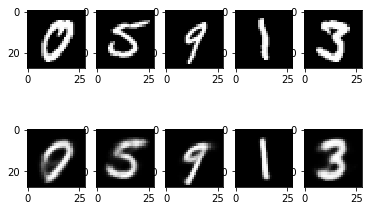

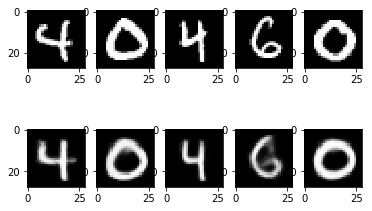

New generated images...


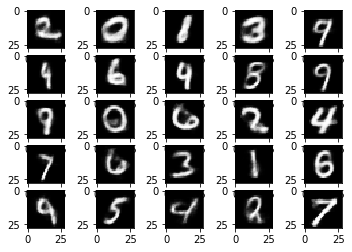

Epoch 10:
Train Losses
KL Loss: 11.1428681464	RC Loss: 16.3659936763	Total Loss: 27.5088618104

Epoch 10:
Validation Losses
KL Loss: 11.0905739222	RC Loss: 16.3710805942	Total Loss: 27.4616544675

Epoch 11:
Train Losses
KL Loss: 11.2005560612	RC Loss: 16.0996196067	Total Loss: 27.3001756701

Epoch 11:
Validation Losses
KL Loss: 11.3167090416	RC Loss: 16.1952097477	Total Loss: 27.5119187282

Epoch 12:
Train Losses
KL Loss: 11.3032634666	RC Loss: 15.8669342057	Total Loss: 27.1701976789

Epoch 12:
Validation Losses
KL Loss: 10.9817783282	RC Loss: 16.4724358901	Total Loss: 27.4542143161

Epoch 13:
Train Losses
KL Loss: 11.3601844785	RC Loss: 15.6502921479	Total Loss: 27.0104766419

Epoch 13:
Validation Losses
KL Loss: 11.8753480667	RC Loss: 15.5502359072	Total Loss: 27.4255840350

Epoch 14:
Train Losses
KL Loss: 11.4144366468	RC Loss: 15.4309882507	Total Loss: 26.8454248719

Epoch 14:
Validation Losses
KL Loss: 10.7751521697	RC Loss: 16.5117998857	Total Loss: 27.2869520921

Epoch 15:
Train

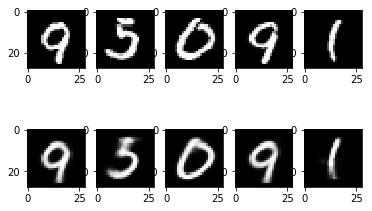

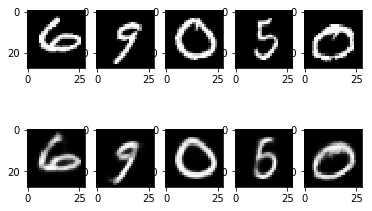

New generated images...


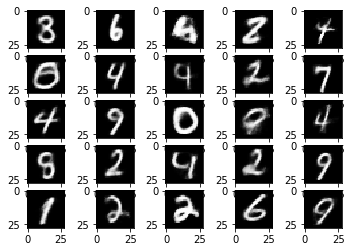

Epoch 20:
Train Losses
KL Loss: 11.7322148810	RC Loss: 14.4523462355	Total Loss: 26.1845611088

Epoch 20:
Validation Losses
KL Loss: 11.9574142114	RC Loss: 15.2037274410	Total Loss: 27.1611415912

Epoch 21:
Train Losses
KL Loss: 11.7859390123	RC Loss: 14.3007622320	Total Loss: 26.0867012477

Epoch 21:
Validation Losses
KL Loss: 11.5851711982	RC Loss: 15.5117863753	Total Loss: 27.0969576224

Epoch 22:
Train Losses
KL Loss: 11.8304178140	RC Loss: 14.1754030443	Total Loss: 26.0058208395

Epoch 22:
Validation Losses
KL Loss: 12.2398613172	RC Loss: 15.0200473223	Total Loss: 27.2599087006

Epoch 23:
Train Losses
KL Loss: 11.8926303006	RC Loss: 14.0495659447	Total Loss: 25.9421962254

Epoch 23:
Validation Losses
KL Loss: 11.7586472585	RC Loss: 15.2812295205	Total Loss: 27.0398768156

Epoch 24:
Train Losses
KL Loss: 11.9070497531	RC Loss: 13.9151860072	Total Loss: 25.8222357780

Epoch 24:
Validation Losses
KL Loss: 11.8083267701	RC Loss: 15.1187968254	Total Loss: 26.9271235833

Epoch 25:
Train

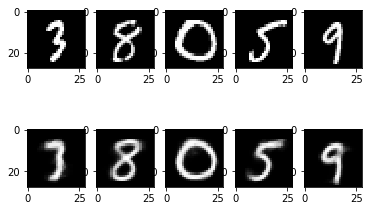

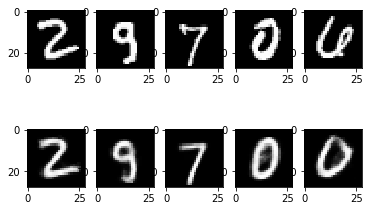

New generated images...


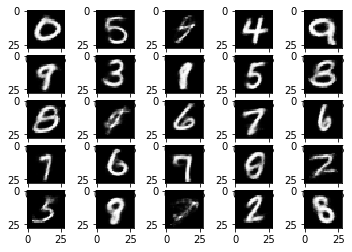

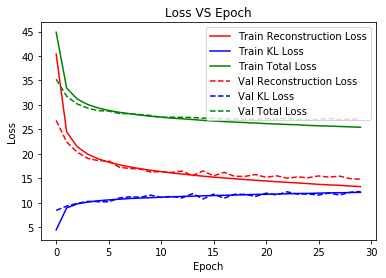

In [60]:
run(encoding_size=8,n_epochs=30)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(?, ?, ?, 64)
output (?, 28, 28, 1)
Epoch 0:
Train Losses
KL Loss: 4.1909315412	RC Loss: 42.6942073413	Total Loss: 46.8851389857

Epoch 0:
Validation Losses
KL Loss: 8.0528444082	RC Loss: 31.4969847508	Total Loss: 39.5498291896

Epoch 1:
Train Losses
KL Loss: 8.5943891833	RC Loss: 29.6146325077	Total Loss: 38.2090217093

Epoch 1:
Validation Losses
KL Loss: 9.3181395286	RC Loss: 27.4749680544	Total Loss: 36.7931076441

Epoch 2:
Train Losses
KL Loss: 9.4728441549	RC Loss: 26.2144909593	Total Loss: 35.6873350687

Epoch 2:
Validation Losses
KL Loss: 9.4816251290	RC Loss: 24.7366175285	Total Loss: 34.2182429387

Epoch 3:
Train Losses
KL Loss: 9.9790173110	RC Loss: 23.4454331048	Total Loss: 33.4244504069

Epoch 3:
Validation Losses
KL Loss: 10.9209326842	RC Loss: 21.2439426275	Total Loss: 32.164875177

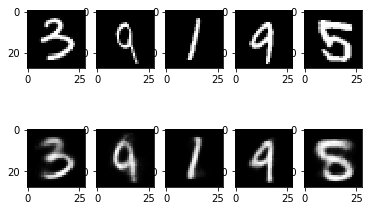

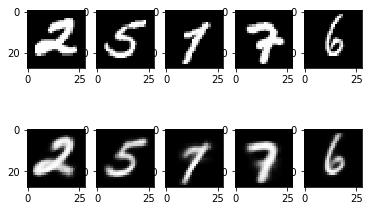

New generated images...


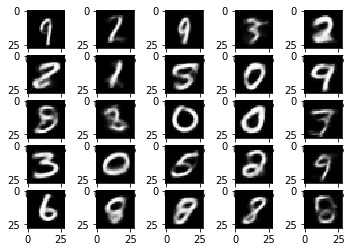

Epoch 10:
Train Losses
KL Loss: 11.7418024576	RC Loss: 16.0382003851	Total Loss: 27.7800028493

Epoch 10:
Validation Losses
KL Loss: 11.1798507862	RC Loss: 16.7283322261	Total Loss: 27.9081829756

Epoch 11:
Train Losses
KL Loss: 11.8107069802	RC Loss: 15.7138202543	Total Loss: 27.5245272378

Epoch 11:
Validation Losses
KL Loss: 12.1159852101	RC Loss: 15.5671780415	Total Loss: 27.6831631783

Epoch 12:
Train Losses
KL Loss: 11.9093977192	RC Loss: 15.4146912412	Total Loss: 27.3240889504

Epoch 12:
Validation Losses
KL Loss: 11.8474131120	RC Loss: 15.7261850773	Total Loss: 27.5735982259

Epoch 13:
Train Losses
KL Loss: 12.0104494983	RC Loss: 15.1462090784	Total Loss: 27.1566585567

Epoch 13:
Validation Losses
KL Loss: 11.6491094125	RC Loss: 15.9843757580	Total Loss: 27.6334850849

Epoch 14:
Train Losses
KL Loss: 12.0733079799	RC Loss: 14.9277891752	Total Loss: 27.0010971562

Epoch 14:
Validation Losses
KL Loss: 11.7487859237	RC Loss: 15.6728505355	Total Loss: 27.4216364102

Epoch 15:
Train

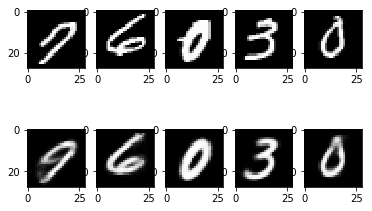

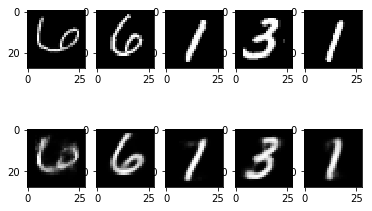

New generated images...


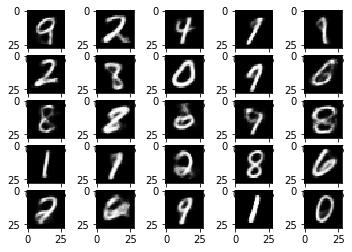

Epoch 20:
Train Losses
KL Loss: 12.4349872147	RC Loss: 13.8174148633	Total Loss: 26.2524020736

Epoch 20:
Validation Losses
KL Loss: 12.0804217901	RC Loss: 15.0390020028	Total Loss: 27.1194239152

Epoch 21:
Train Losses
KL Loss: 12.4887545200	RC Loss: 13.6907887087	Total Loss: 26.1795432165

Epoch 21:
Validation Losses
KL Loss: 12.7005564739	RC Loss: 14.6919471790	Total Loss: 27.3925035917

Epoch 22:
Train Losses
KL Loss: 12.5498841911	RC Loss: 13.5353667722	Total Loss: 26.0852509500

Epoch 22:
Validation Losses
KL Loss: 12.3799307652	RC Loss: 14.7364164132	Total Loss: 27.1163471907

Epoch 23:
Train Losses
KL Loss: 12.5819958897	RC Loss: 13.4062493261	Total Loss: 25.9882452147

Epoch 23:
Validation Losses
KL Loss: 12.5269938004	RC Loss: 14.5901585970	Total Loss: 27.1171523852

Epoch 24:
Train Losses
KL Loss: 12.6294912720	RC Loss: 13.2723344463	Total Loss: 25.9018256972

Epoch 24:
Validation Losses
KL Loss: 12.6098051438	RC Loss: 14.6246249003	Total Loss: 27.2344301175

Epoch 25:
Train

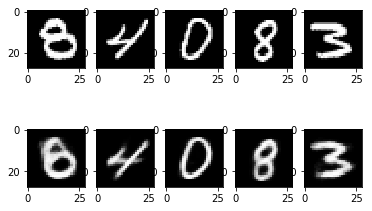

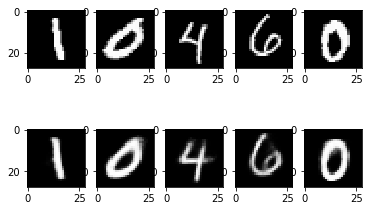

New generated images...


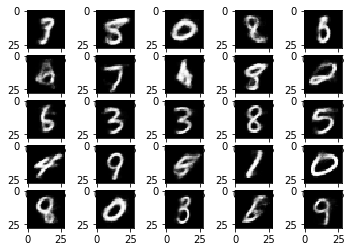

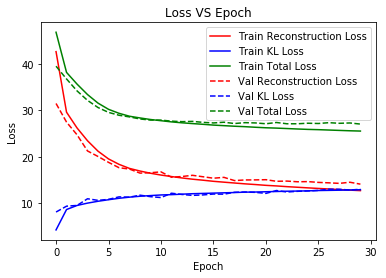

In [61]:
run(encoding_size=32,n_epochs=30)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(?, ?, ?, 64)
output (?, 28, 28, 1)
Epoch 0:
Train Losses
KL Loss: 4.0355761746	RC Loss: 43.5647872796	Total Loss: 47.6003634594

Epoch 0:
Validation Losses
KL Loss: 6.6512706952	RC Loss: 35.0549931648	Total Loss: 41.7062640068

Epoch 1:
Train Losses
KL Loss: 7.6727794785	RC Loss: 33.0817659287	Total Loss: 40.7545454139

Epoch 1:
Validation Losses
KL Loss: 7.9686473394	RC Loss: 31.5126115603	Total Loss: 39.4812586858

Epoch 2:
Train Losses
KL Loss: 8.4601378741	RC Loss: 30.8985479619	Total Loss: 39.3586858809

Epoch 2:
Validation Losses
KL Loss: 8.3192917934	RC Loss: 29.8907412505	Total Loss: 38.2100328299

Epoch 3:
Train Losses
KL Loss: 8.8665717711	RC Loss: 29.4880364477	Total Loss: 38.3546082582

Epoch 3:
Validation Losses
KL Loss: 9.6426643836	RC Loss: 27.8055543166	Total Loss: 37.4482188103

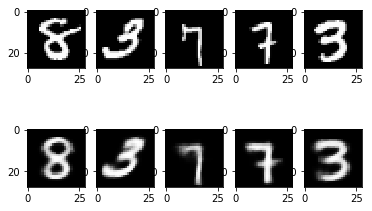

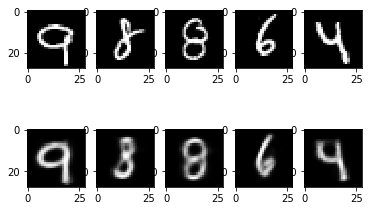

New generated images...


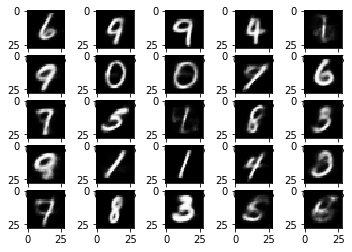

Epoch 10:
Train Losses
KL Loss: 10.5213448155	RC Loss: 18.7526025928	Total Loss: 29.2739473993

Epoch 10:
Validation Losses
KL Loss: 10.8614268181	RC Loss: 18.1852399264	Total Loss: 29.0466666833

Epoch 11:
Train Losses
KL Loss: 10.7037990801	RC Loss: 18.0204418091	Total Loss: 28.7242408637

Epoch 11:
Validation Losses
KL Loss: 10.8414716965	RC Loss: 17.6799066495	Total Loss: 28.5213783704

Epoch 12:
Train Losses
KL Loss: 10.8380784555	RC Loss: 17.5232679713	Total Loss: 28.3613464213

Epoch 12:
Validation Losses
KL Loss: 10.5817155471	RC Loss: 17.7503615282	Total Loss: 28.3320770997

Epoch 13:
Train Losses
KL Loss: 10.9693346790	RC Loss: 17.0770015095	Total Loss: 28.0463361862

Epoch 13:
Validation Losses
KL Loss: 11.1065114828	RC Loss: 16.8372454888	Total Loss: 27.9437569349

Epoch 14:
Train Losses
KL Loss: 11.0611907772	RC Loss: 16.7279773319	Total Loss: 27.7891680947

Epoch 14:
Validation Losses
KL Loss: 11.3366429133	RC Loss: 16.6501464232	Total Loss: 27.9867894099

Epoch 15:
Train

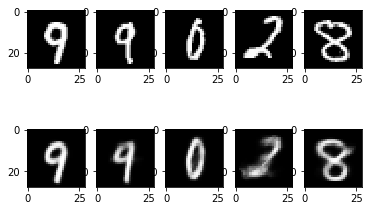

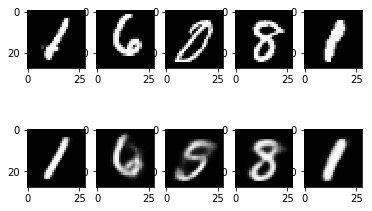

New generated images...


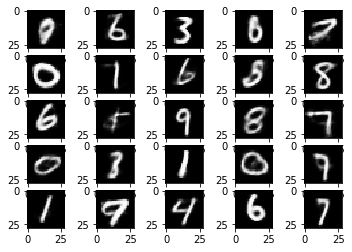

Epoch 20:
Train Losses
KL Loss: 11.5310886592	RC Loss: 15.2438978955	Total Loss: 26.7749865557

Epoch 20:
Validation Losses
KL Loss: 11.3344770945	RC Loss: 16.0521599207	Total Loss: 27.3866370519

Epoch 21:
Train Losses
KL Loss: 11.5870369821	RC Loss: 15.0462187932	Total Loss: 26.6332557732

Epoch 21:
Validation Losses
KL Loss: 11.3323491903	RC Loss: 16.1150022409	Total Loss: 27.4473514801

Epoch 22:
Train Losses
KL Loss: 11.6529376715	RC Loss: 14.8739250536	Total Loss: 26.5268626740

Epoch 22:
Validation Losses
KL Loss: 11.8321650823	RC Loss: 15.5377119994	Total Loss: 27.3698770817

Epoch 23:
Train Losses
KL Loss: 11.6830216620	RC Loss: 14.7038093929	Total Loss: 26.3868310349

Epoch 23:
Validation Losses
KL Loss: 11.4151008557	RC Loss: 15.9240613962	Total Loss: 27.3391622397

Epoch 24:
Train Losses
KL Loss: 11.7345257161	RC Loss: 14.5449174719	Total Loss: 26.2794431702

Epoch 24:
Validation Losses
KL Loss: 11.7302680382	RC Loss: 15.5278864151	Total Loss: 27.2581543556

Epoch 25:
Train

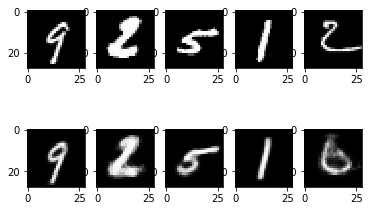

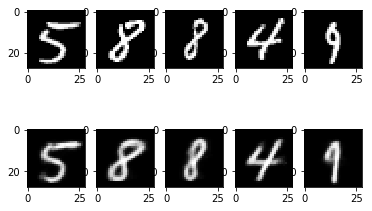

New generated images...


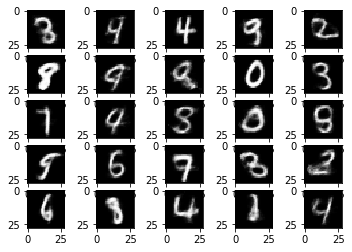

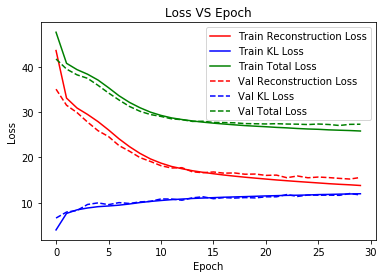

In [62]:
run(encoding_size=128,n_epochs=30)